# Data Preparation

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## 0. Setup parameters and load libraries

In [1]:
import os
import sys

import requests
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import quilt
import rasterio
import rasterio.mask
import rasterio.plot
import shapely.geometry
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Rasterio     :', rasterio.__version__)

Python       : 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
Numpy        : 1.14.5
Rasterio     : 1.0.3.post1


## 1. Get Data!

### Download Low Resolution data (e.g. [BEDMAP2](https://doi.org/10.5194/tc-7-375-2013))

In [2]:
url = "http://data.pgc.umn.edu/elev/dem/bedmap2/bedmap2_bed.tif"  #link to BEDMAP2 Bed Elevation GeoTiff
path = "lowres/bedmap2_bed.tif"  #path to download the file to

if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

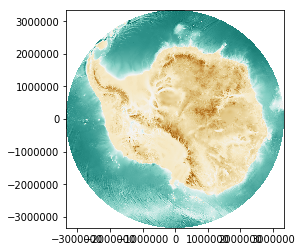

In [3]:
with rasterio.open("lowres/bedmap2_bed.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap='BrBG_r')

### Download High Resolution data (e.g. some-DEM-name)

In [4]:
url = "http://ramadda.nerc-bas.ac.uk/repository/entry/get/Polar%20Data%20Centre/DOI/Rutford%20Ice%20Stream%20bed%20elevation%20DEM%20from%20radar%20data/bed_WGS84_grid.txt?entryid=synth%3A54757cbe-0b13-4385-8b31-4dfaa1dab55e%3AL2JlZF9XR1M4NF9ncmlkLnR4dA%3D%3D"
path = "highres/bed_WGS84_grid.tif"  #path to download the file to

if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

## 2. Process high resolution data into grid format

[ASCII Text](https://pdal.io/stages/readers.text.html) ----> [GeoTIFF](https://pdal.io/stages/writers.gdal.html)

In [5]:
!cd highres && pdal pipeline --nostream -i bed_WGS84_grid.json

TODO:
- use Python bindings instead of shell
- make it work on more files

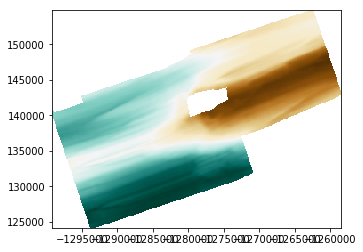

In [6]:
with rasterio.open("highres/bed_WGS84_grid.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap='BrBG_r')

## 3. Tile data

### Process High Resolution data

In [7]:
def hi_res_tile(filepath:str, height:int=64, width:int=64):
    """
    Reads in the low resolution rasters and tiles them.
    Tiles will be fit to the low resolution dataset bounds.
    """
    
    assert(height==width)  #make sure it's a square!
    array_list = []
    window_bounds = []  #list to store the geographic bounding box of each crop
    
    with rasterio.open(filepath) as dataset:
        #Loop along the raster image from top to bottom, and left to right
        for uly in range(0, dataset.shape[0], int(height/4)):
            for ulx in range(0, dataset.shape[1], int(width/4)):
                
                #Create a cropping window, and get the geographic bounds too
                window = rasterio.windows.Window(col_off=ulx, row_off=uly, width=width, height=height)
                window_bound = rasterio.windows.bounds(window=window, transform=dataset.transform)
                
                #Read the raster according to the crop window
                array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window, out_shape=(height,width))
                array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
                
                #Check if the raster is a full raster, i.e. no blank/NODATA
                if not array.mask.any():
                    array_list.append(array.data)
                    window_bounds.append(window_bound)
    
    return np.stack(arrays=array_list), window_bounds

In [8]:
hires, window_bounds = hi_res_tile(filepath="highres/bed_WGS84_grid.tif")
print(hires.shape, hires.dtype)

(26, 64, 64, 1) float32


### Process low resolution data

In [9]:
def lo_res_tile(filepath:str, window_bounds:list):
    """
    Reads in high resolution raster and tiles them.
    Tiles will go according to list of window_bounds
    """
    
    array_list = []
    
    with rasterio.open(filepath) as dataset:
        for window_bound in window_bounds:
            window = rasterio.windows.from_bounds(*window_bound, transform=dataset.transform)
        
            #Read the raster according to the crop window
            array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window)
            array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
    
            assert(not array.mask.any())
            array_list.append(array.data.astype(dtype=np.float32))
    
    return np.stack(arrays=array_list)

In [10]:
lores = lo_res_tile(filepath="lowres/bedmap2_bed.tif", window_bounds=window_bounds)
print(lores.shape, lores.dtype)

(26, 8, 8, 1) float32


### Show tiles

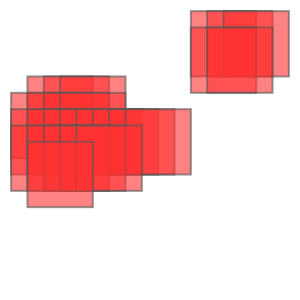

In [11]:
#shapely.geometry.box(*window_bound)
shapely.geometry.MultiPolygon([shapely.geometry.box(*bound) for bound in window_bounds])

## 4. Save the arrays

We'll save the numpy arrays to the filesystem first.

Also, we'll serve the data up on the web using:
- [Quilt](https://quiltdata.com/) - Python data versioning
- [Dat](https://datproject.org/) - Distributed data sharing (TODO)

In [12]:
os.makedirs(name="model/train", exist_ok=True)
np.save(file="model/train/X_data.npy", arr=hires)
np.save(file="model/train/Y_data.npy", arr=lores)

### Quilt

Login -> Build -> Push

In [13]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login



Enter the code from the webpage:  eyJpZCI6ICIyOWI4YzUyNS1lZmM1LTQ5NTItOGQ4Yy03NzQyYTg1YmI1MmEiLCAiY29kZSI6ICJiODkxYTVhNy01ZjdjLTQ0OWYtYTBhNS1mNWViZWNhODU4OTIifQ==


In [14]:
quilt.build(package='weiji14/deepbedmap/model/train/X_data', path=hires)
quilt.build(package='weiji14/deepbedmap/model/train/Y_data', path=lores)

In [15]:
quilt.push(package='weiji14/deepbedmap', is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/433k [00:00<?, ?B/s]

Uploading 2 fragments (432896 bytes)...


100%|██████████| 433k/433k [00:02<00:00, 149kB/s] 


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/deepbedmap is live:
https://quiltdata.com/package/weiji14/deepbedmap
